In [1]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [6]:
pip install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import cv2

In [8]:
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

In [10]:
from sklearn.model_selection import train_test_split

In [13]:
import tensorflow as tf

In [15]:
from tensorflow.keras.models import Model

In [16]:
from keras.layers import *
#from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [17]:
IMAGE_LIB = '2d_images/'
MASK_LIB = '2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED=42

In [18]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

In [19]:
print(all_images)


['ID_0000_Z_0142.tif', 'ID_0001_Z_0146.tif', 'ID_0002_Z_0162.tif', 'ID_0003_Z_0132.tif', 'ID_0004_Z_0066.tif', 'ID_0005_Z_0066.tif', 'ID_0006_Z_0206.tif', 'ID_0007_Z_0211.tif', 'ID_0008_Z_0065.tif', 'ID_0009_Z_0114.tif', 'ID_0010_Z_0259.tif', 'ID_0011_Z_0156.tif', 'ID_0012_Z_0167.tif', 'ID_0013_Z_0047.tif', 'ID_0014_Z_0116.tif', 'ID_0015_Z_0136.tif', 'ID_0016_Z_0208.tif', 'ID_0017_Z_0061.tif', 'ID_0018_Z_0069.tif', 'ID_0019_Z_0088.tif', 'ID_0020_Z_0070.tif', 'ID_0021_Z_0066.tif', 'ID_0022_Z_0131.tif', 'ID_0023_Z_0241.tif', 'ID_0024_Z_0086.tif', 'ID_0025_Z_0112.tif', 'ID_0026_Z_0140.tif', 'ID_0027_Z_0125.tif', 'ID_0028_Z_0125.tif', 'ID_0029_Z_0059.tif', 'ID_0030_Z_0302.tif', 'ID_0031_Z_0232.tif', 'ID_0032_Z_0055.tif', 'ID_0033_Z_0278.tif', 'ID_0034_Z_0066.tif', 'ID_0035_Z_0224.tif', 'ID_0036_Z_0060.tif', 'ID_0037_Z_0150.tif', 'ID_0038_Z_0148.tif', 'ID_0039_Z_0112.tif', 'ID_0040_Z_0066.tif', 'ID_0041_Z_0336.tif', 'ID_0042_Z_0366.tif', 'ID_0043_Z_0097.tif', 'ID_0044_Z_0116.tif', 'ID_0045_

In [20]:
x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')

In [21]:
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

In [22]:
y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

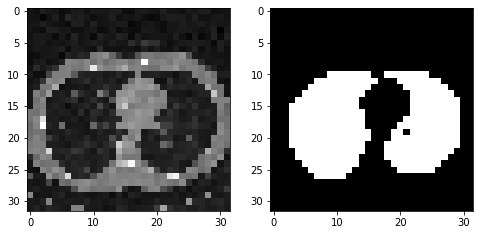

In [23]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[12], cmap='gray')
ax[1].imshow(y_data[12], cmap='gray')
plt.show()

In [24]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [26]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)


2022-04-27 10:21:12.142936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-27 10:21:12.142960: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 10:21:12.142976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-tema): /proc/driver/nvidia/version does not exist
2022-04-27 10:21:12.143120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   1168        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [28]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

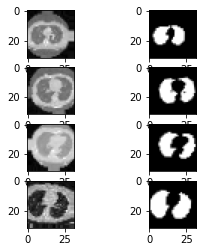

In [29]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(4,2, figsize=(4,4))
for i in range(4):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap ='gray')
plt.show()

In [31]:
model.compile( loss='binary_crossentropy', metrics=[dice_coef])

In [32]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [33]:
hist = model.fit(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

2022-04-27 10:21:56.101590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
200/200 - 3s - loss: 0.3190 - dice_coef: 0.5666 - val_loss: 0.1660 - val_dice_coef: 0.7567
Epoch 2/10
200/200 - 2s - loss: 0.1830 - dice_coef: 0.7715 - val_loss: 0.1323 - val_dice_coef: 0.8299
Epoch 3/10
200/200 - 2s - loss: 0.1624 - dice_coef: 0.8045 - val_loss: 0.1105 - val_dice_coef: 0.8515
Epoch 4/10
200/200 - 2s - loss: 0.1513 - dice_coef: 0.8204 - val_loss: 0.1006 - val_dice_coef: 0.8621
Epoch 5/10
200/200 - 2s - loss: 0.1428 - dice_coef: 0.8315 - val_loss: 0.1006 - val_dice_coef: 0.8724
Epoch 6/10
200/200 - 2s - loss: 0.1367 - dice_coef: 0.8387 - val_loss: 0.0996 - val_dice_coef: 0.8723
Epoch 7/10
200/200 - 2s - loss: 0.1328 - dice_coef: 0.8426 - val_loss: 0.0902 - val_dice_coef: 0.8738
Epoch 8/10
200/200 - 2s - loss: 0.1298 - dice_coef: 0.8454 - val_loss: 0.0917 - val_dice_coef: 0.8782
Epoch 9/10
200/200 - 2s - loss: 0.1280 - dice_coef: 0.8478 - val_loss: 0.0874 - val_dice_coef: 0.8834
Epoch 10/10
200/200 - 2s - loss: 0.1276 - dice_coef: 0.8487 - val_loss: 0.0876 - v

In [26]:
model.load_weights('lung.h5')

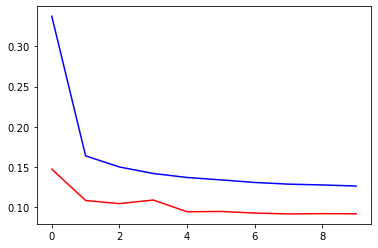

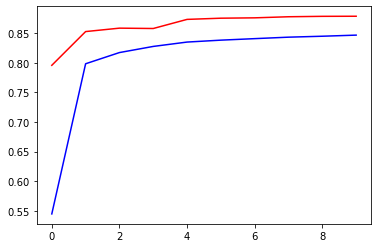

In [27]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

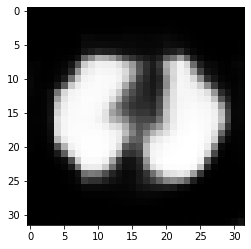

In [28]:
plt.imshow(model.predict(x_train[5].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

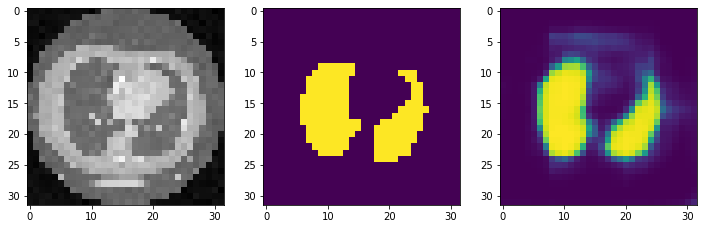

In [29]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [30]:
len(x_val)


134

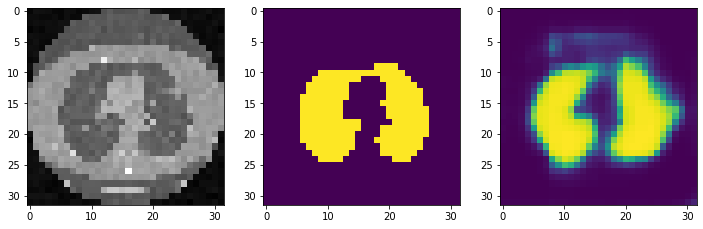

In [31]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[12,:,:,0], cmap='gray')
ax[1].imshow(y_val[12,:,:,0])
ax[2].imshow(y_hat[12,:,:,0])


In [32]:
cv2.imwrite('prediction_12.png',y_hat[12,:,:,0])

True

In [33]:
y_hat_new = 255*y_hat[12,:,:,0]

In [34]:
y_hat_new

array([[4.07490134e-02, 5.84636629e-02, 7.42252171e-02, ...,
        3.21569480e-03, 9.30646062e-02, 4.39393222e-01],
       [4.13569808e-02, 6.41025603e-02, 1.02054924e-01, ...,
        5.55640273e-03, 1.29717439e-01, 4.99794781e-01],
       [3.80283594e-02, 6.59872591e-02, 1.44255459e-01, ...,
        8.79370701e-03, 1.45144612e-01, 5.64809322e-01],
       ...,
       [6.93766773e-02, 9.44629312e-02, 1.36572272e-01, ...,
        1.38464570e-01, 8.66756320e-01, 3.12448120e+00],
       [1.89571828e-01, 2.35891342e-01, 3.18369716e-01, ...,
        5.71747720e-01, 2.43617082e+00, 7.06507492e+00],
       [2.02293539e+00, 2.03134823e+00, 2.26333332e+00, ...,
        5.15218163e+00, 1.30694447e+01, 2.52258892e+01]], dtype=float32)

In [35]:
y_hat_new.astype(int)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  3],
       [ 0,  0,  0, ...,  0,  2,  7],
       [ 2,  2,  2, ...,  5, 13, 25]])

In [36]:
cv2.imwrite('prediction_12.png',y_hat_new)

True